-  reference : https://www.kaggle.com/javalex/nyc-bike-data-analysis-subscribers-and-customers

In [1]:

import numpy as np
import pandas as pd
import geopandas
from shapely.geometry import Point, Polygon

import os 
import sys

import calendar
import glob
import math

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('NYC-BikeShare-2015-2017-combined.csv')

In [3]:
df.head()

,Unnamed: 0,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender,Trip_Duration_in_min
0,0,376,2015-10-01 00:16:26,2015-10-01 00:22:42,3212,Christ Hospital,40.734786,-74.050444,3207,Oakland Ave,40.737604,-74.052478,24470,Subscriber,1960.0,1,6
1,1,739,2015-10-01 00:27:12,2015-10-01 00:39:32,3207,Oakland Ave,40.737604,-74.052478,3212,Christ Hospital,40.734786,-74.050444,24481,Subscriber,1960.0,1,12
2,2,2714,2015-10-01 00:32:46,2015-10-01 01:18:01,3193,Lincoln Park,40.724605,-74.078406,3193,Lincoln Park,40.724605,-74.078406,24628,Subscriber,1983.0,1,45
3,3,275,2015-10-01 00:34:31,2015-10-01 00:39:06,3199,Newport Pkwy,40.728745,-74.032108,3187,Warren St,40.721124,-74.038051,24613,Subscriber,1975.0,1,5
4,4,561,2015-10-01 00:40:12,2015-10-01 00:49:33,3183,Exchange Place,40.716247,-74.033459,3192,Liberty Light Rail,40.711242,-74.055701,24668,Customer,1984.0,0,9


## parameter

In [12]:
YEAR = 2017

#age
AGE_REANGES = ['<20','20-29','30-39','40-49','50-59','60+'] # 각 나이 범위를 구함
AGE_RANGES_LIMITS = [0, 20, 30, 40, 50, 60, np.inf]
AGE_MIN = 0
AGE_MAX = 100

# trip duration
DURATION_MIN = 2 # 2초 이상 사용한 사람이 최소 사용이라고 말할 수 있다
DURATION_MAX = 30 * 24 * 60 * 60 # 30일 사용

USERTYPES = ['all', 'subscriber','customer']

#plotting
FONT_SCALE = 1.5


## data validation

### load data :

In [5]:
df = pd.read_csv('NYC-BikeShare-2015-2017-combined.csv')
df.describe()

,Unnamed: 0,Trip Duration,Start Station ID,Start Station Latitude,Start Station Longitude,End Station ID,End Station Latitude,End Station Longitude,Bike ID,Birth Year,Gender,Trip_Duration_in_min
count,735502.000000,7.355020e+05,735502.000000,735502.000000,735502.000000,735502.000000,735502.000000,735502.000000,735502.000000,735502.000000,735502.000000,735502.000000
mean,10582.401084,9.343125e+02,3206.764183,40.723125,-74.046412,3203.387325,40.722371,-74.045415,24914.009133,1979.544239,1.123668,15.570669
std,7679.871929,4.063878e+04,26.546683,0.008121,0.011191,64.358120,0.095296,0.173044,753.768581,9.371192,0.519694,677.312437
min,0.000000,6.100000e+01,3183.000000,40.692640,-74.096937,147.000000,0.000000,-74.096937,14552.000000,1900.000000,0.000000,1.000000
25%,4484.000000,2.460000e+02,3186.000000,40.717732,-74.050656,3186.000000,40.716540,-74.050444,24486.000000,1975.000000,1.000000,4.000000
50%,9156.000000,3.830000e+02,3202.000000,40.721525,-74.044247,3199.000000,40.721124,-74.043845,24602.000000,1982.000000,1.000000,6.000000
75%,15003.000000,6.520000e+02,3211.000000,40.727596,-74.038051,3211.000000,40.727224,-74.036486,24711.000000,1986.000000,1.000000,11.000000
max,34148.000000,2.026021e+07,3426.000000,40.752559,-74.032108,3442.000000,40.801343,0.000000,29296.000000,2000.000000,2.000000,337670.000000


In [6]:
# 시간관련 문자 데이터를 datetime 으로 변경
df['Start time'] = pd.to_datetime(df['Start Time'])
df['Stop Time'] = pd.to_datetime(df['Stop Time'])
df['Birth Year'] = pd.to_numeric(df['Birth Year'], downcast='integer') # 태어난 날을 정수화
df.drop(['Unnamed: 0'], axis=1, inplace=True) # 불필요한 칼럼 삭제
df.head()


,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender,Trip_Duration_in_min,Start time
0,376,2015-10-01 00:16:26,2015-10-01 00:22:42,3212,Christ Hospital,40.734786,-74.050444,3207,Oakland Ave,40.737604,-74.052478,24470,Subscriber,1960,1,6,2015-10-01 00:16:26
1,739,2015-10-01 00:27:12,2015-10-01 00:39:32,3207,Oakland Ave,40.737604,-74.052478,3212,Christ Hospital,40.734786,-74.050444,24481,Subscriber,1960,1,12,2015-10-01 00:27:12
2,2714,2015-10-01 00:32:46,2015-10-01 01:18:01,3193,Lincoln Park,40.724605,-74.078406,3193,Lincoln Park,40.724605,-74.078406,24628,Subscriber,1983,1,45,2015-10-01 00:32:46
3,275,2015-10-01 00:34:31,2015-10-01 00:39:06,3199,Newport Pkwy,40.728745,-74.032108,3187,Warren St,40.721124,-74.038051,24613,Subscriber,1975,1,5,2015-10-01 00:34:31
4,561,2015-10-01 00:40:12,2015-10-01 00:49:33,3183,Exchange Place,40.716247,-74.033459,3192,Liberty Light Rail,40.711242,-74.055701,24668,Customer,1984,0,9,2015-10-01 00:40:12


In [7]:
# 무시해야할 필요가 있는 칼럼을 우선 생성해둠
df["ignore"] = False 
df["ignore_reason"] = ""

In [8]:
# df.shape = (735502,20) 이나 
duplicates = df.duplicated(subset=None, keep='first') # 중복여부 확인, 중복이 있다면 첫번째 값만 남긴다
# duplicates 는 해당 값이 True / False 로 된 값을 가지고 있음

df.insert(len(df.columns), "duplicate", duplicates, allow_duplicates = True)
# df 라는 이름의 dataframe 에 len(df.columns) 번째에 'duplicate' 라는 이름의 칼럼을 넣어라
# 실제 값은 duplicates 를 넣는 것

print("Found {} duplicate rows".format(len(df[duplicates])))
# df[duplicates] 는 df.duplicate = True 인 것만 불러오는 것


Found 395882 duplicate rows


In [9]:
# df bike id, start station id, end station 이 값이 없다면, ignore_reason 칼럼 값에 값 추가
df.loc[df["Bike ID"].isna(), "ignore_reason"] += "Bike ID empty; "
df.loc[df["Start Station ID"].isna(), "ignore_reason"] += "Start Station empty; "
df.loc[df["End Station ID"].isna(), "ignore_reason"] += "End Station empty; "

# 
df.loc[~df["User Type"].isin(["Subscriber", "Customer"]), "ignore_reason"] += "User Type invalid; "


In [17]:
df["age"] = YEAR - df["Birth Year"] # 태어난 날부터 2017까지 나이라는 칼럼 할당해서 계산
print("Max age: {}.".format(df["age"].max())) # 최대값 확인

# 나보다 높고 낮을때 'implausible age' 라는 단어를 넣어줌
df.loc[df["age"] > AGE_MAX, "ignore_reason"] += "implausible age; " 
df.loc[df["age"] < AGE_MIN, "ignore_reason"] += "implausible age; "

# 자전거 탄 사람의 시간 최소, 최대값 확인
print("Min duration: {}.".format(df["Trip Duration"].min()))
df.loc[df["Trip Duration"] < DURATION_MIN, "ignore_reason"] += "Trip Duration implausible; "

print("Max duration: {}.".format(df["Trip Duration"].max()))
df.loc[df["Trip Duration"] > DURATION_MAX, "ignore_reason"] += "Trip Duration implausible; "

# 중복된 값이 있다면 중복되었다고 표기
df.loc[df["duplicate"] == True, "ignore_reason"] += "duplicate; "

Max age: 117.
Min duration: 61.
Max duration: 20260211.


## 데이터 분석

In [18]:
df_subscribers = df[df["User Type"] == "Subscriber"]
df_customers = df[df["User Type"] == "Customer"]
DATAFRAMES = [df, df_subscribers, df_customers]

In [19]:
from numpy.random import seed
seed(4)

### 연령 기반 분포 확인

all
count    688140.000000
mean          1.200802
std           0.442696
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           2.000000
Name: Gender, dtype: float64


/Users/jinseulpark/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


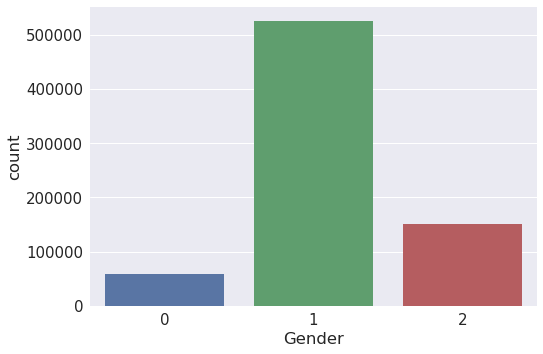

subscriber
count    688140.000000
mean          1.200802
std           0.442696
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           2.000000
Name: Gender, dtype: float64


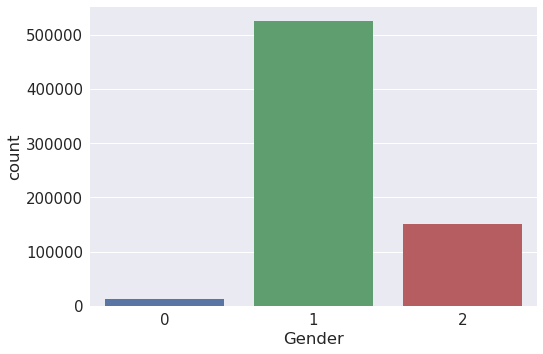

customer
count    688140.000000
mean          1.200802
std           0.442696
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           2.000000
Name: Gender, dtype: float64


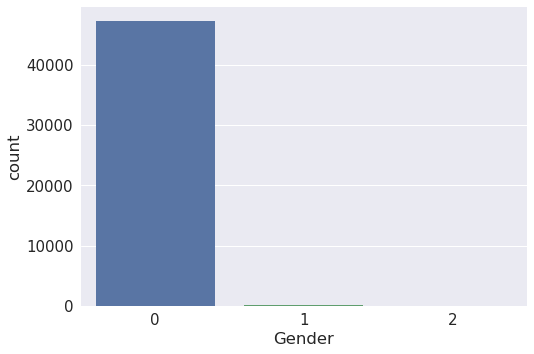

In [22]:
for i in range(3):
    dfr = DATAFRAMES[1] 
    print(USERTYPES[i])
    print(dfr["Gender"].describe())
    with sns.plotting_context("notebook", font_scale = FONT_SCALE):
        f = sns.countplot(x = "Gender", data = DATAFRAMES[i])
        plt.show()

- 전체 유저 중, gender = 1 의 유저수가 가장 많다
- 구독자의 경우에도, gender = 1 수가 가장 많다
- 구독자가 아닌 경우, 대부분 때문에 0이 많다

###